In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn, optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Dataset loaded successfully!
Columns in dataset: Index(['Date', 'Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble'],
      dtype='object')
Final dataset preview:
            Symbol Series  Prev Close   Open    High    Low   Last   Close  \
Date                                                                        
2000-01-03   HDFC     EQ      271.75  293.5  293.50  293.5  293.5  293.50   
2000-01-04   HDFC     EQ      293.50  317.0  317.00  297.0  304.0  304.05   
2000-01-05   HDFC     EQ      304.05  290.0  303.90  285.0  295.0  292.80   
2000-01-06   HDFC     EQ      292.80  301.0  314.00  295.0  296.0  296.45   
2000-01-07   HDFC     EQ      296.45  290.0  296.35  281.0  287.1  286.55   

              VWAP  Volume      Turnover  Trades  Deliverable Volume  \
Date                                                                   
2000-01-03  293.50   22744  6.675364e+11

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20, Loss: 0.0021
Epoch 2/20, Loss: 0.0004
Epoch 3/20, Loss: 0.0015
Epoch 4/20, Loss: 0.0002
Epoch 5/20, Loss: 0.0005
Epoch 6/20, Loss: 0.0007
Epoch 7/20, Loss: 0.0007
Epoch 8/20, Loss: 0.0021
Epoch 9/20, Loss: 0.0003
Epoch 10/20, Loss: 0.0005
Epoch 11/20, Loss: 0.0012
Epoch 12/20, Loss: 0.0004
Epoch 13/20, Loss: 0.0005
Epoch 14/20, Loss: 0.0004
Epoch 15/20, Loss: 0.0008
Epoch 16/20, Loss: 0.0002
Epoch 17/20, Loss: 0.0006
Epoch 18/20, Loss: 0.0008
Epoch 19/20, Loss: 0.0003
Epoch 20/20, Loss: 0.0006
Model training completed and saved!


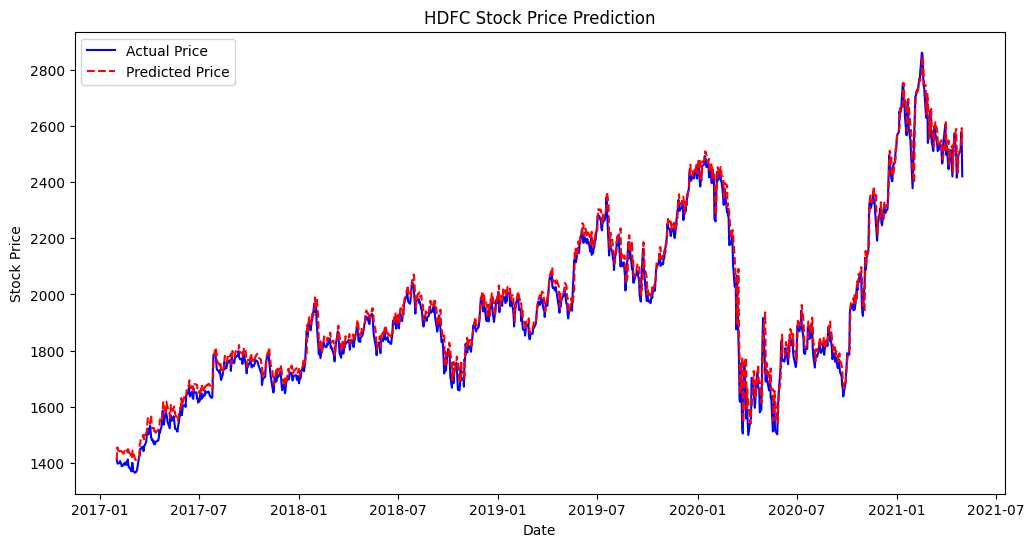

In [ ]:
# Load dataset with debugging
def get_stock_data(file_path):
    try:
        df = pd.read_csv(file_path)
        print("Dataset loaded successfully!")
        print("Columns in dataset:", df.columns)

        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df.set_index('Date', inplace=True)

        if 'Close' not in df.columns:
            raise ValueError("Column 'Close' not found in the dataset. Available columns: ", df.columns)

        print("Final dataset preview:\n", df.head())
        return df[['Close']]
    except Exception as e:
        print("Error loading dataset:", e)
        return None  # Return None if loading fails

# Preprocessing pipeline
class StockDataPreprocessor:
    def __init__(self, seq_length=60):
        self.seq_length = seq_length
        self.scaler = MinMaxScaler()

    def transform(self, data):
        if data is None:
            raise ValueError("Input data is None. Check dataset loading.")
        scaled_data = self.scaler.fit_transform(data.reshape(-1, 1))
        sequences, targets = [], []
        for i in range(len(scaled_data) - self.seq_length):
            sequences.append(scaled_data[i:i + self.seq_length])
            targets.append(scaled_data[i + self.seq_length])
        return np.array(sequences), np.array(targets)

# Transformer Model
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim=1, embed_dim=32, num_heads=4, ff_dim=128, num_layers=2):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim)
        self.transformer = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.fc(x[:, -1, :])  # Take last output for prediction
        return x

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        for seqs, labels in train_loader:
            optimizer.zero_grad()
            output = model(seqs.float())
            loss = criterion(output, labels.float())
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

# Plot Predictions
def plot_predictions(actual, predicted, dates):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actual, label="Actual Price", color='blue')
    plt.plot(dates, predicted, label="Predicted Price", color='red', linestyle='dashed')
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title("HDFC Stock Price Prediction")
    plt.legend()
    plt.show()

# Main pipeline
def main():
    file_path = '/content/HDFC.csv'  # HDFC Stock Data
    df = get_stock_data(file_path)
    if df is None or df.empty:
        print("Dataset loading failed or is empty. Exiting.")
        return

    preprocessor = StockDataPreprocessor()
    X, y = preprocessor.transform(df.values)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Convert to PyTorch tensors
    train_data = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

    # Initialize model
    model = TimeSeriesTransformer()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train model
    train_model(model, train_loader, criterion, optimizer, epochs=20)

    # Save model
    torch.save(model.state_dict(), 'transformer_stock_model.pth')
    print("Model training completed and saved!")

    # Make Predictions
    model.eval()
    X_test_tensor = torch.tensor(X_test).float()
    predictions = model(X_test_tensor).detach().numpy()

    # Inverse transform predictions
    predicted_prices = preprocessor.scaler.inverse_transform(predictions)
    actual_prices = preprocessor.scaler.inverse_transform(y_test)

    # Plot results
    plot_predictions(actual_prices, predicted_prices, df.index[-len(y_test):])

if __name__ == "__main__":
    main()
